# All Roads Lead to Kdb: the technical counterpart

This post serves as a follow-up to our prior article, [All Roads Lead to Kdb](https://github.com/hablapps/AllRoadsLeadToKdb/blob/main/posts/AllRoadsLeadToKdb.md), where we introduced the utility of the PyKX library from the perspective of Emma Monad, the CTO of a large fictional company known as Mad Flow. In addition to this high-level perspective, the focus of this post is on Python programmers who are eager to explore the technical intricacies that were left unexplained in the aforementioned article. Consequently, the post will provide them with a highly detailed, step-by-step example of how to migrate an existing Python codebase into PyKX. Similarly to the outcomes presented in the post [Accelerating Python Workflows using PyKX](https://kx.com/blog/accelerating-python-workflows-using-pykx/), which we highly recommend reading, we will observe a significant performance advantage of the resulting PyKX code compared to the initial Pandas implementation. More references are available in the bibliography at the end of the post.

The structure of the post will be as follows:

* [**The Use Case**](#t2): We will begin by explaining the traffic improvement use case itself, encompassing its objectives, data sources, and anticipated outcomes. This section will also include references to the necessary data sources required to execute all the code provided in this post.
* [**PyKX migration**](#t3): Subsequently, we will illustrate the process of delegating resource-intensive tasks to kdb+/q using PyKX, all while staying within the Python environment. This kind of PyKX-boosted Pythonic version is probably the fastest way to begin harnessing the capabilities of the kdb+/q environment.
* [**pykx.q migration**](#t4): Lastly, we will delve into the process of transitioning the code to pure kdb+/q, while continuing to utilize PyKX to retain the Pythonic code you wish to preserve. This kdb+/q version enhanced by PyKX is presented for those interested in a more extensive adoption of kdb+/q.

The initial section regarding the use case is independent of programming languages and is primarily included for reference purposes. If you're eager to delve directly into the code and begin learning how to migrate pure Pandas-based Python code into PyKX, you can proceed to the [second section](#t3) now and revisit the [first section](#t2) as necessary.
    
## Use Case<a class="anchor" id="t2"></a>

With the aim of predicting traffic congestion in the presence of rain, Mad Flow dedicated significant effort to preparing and integrating weather and traffic data into an LSTM model. This endeavor aligned with other [studies](https://www.mdpi.com/1424-8220/20/13/3749) that sought to forecast traffic patterns using LSTM models based on air pollution.  Just like findings from studies in cities such as [Manchester](https://pure.manchester.ac.uk/ws/portalfiles/portal/72721911/DEXA_Camera_8_pages.pdf), [Shenzhen](https://ieeexplore.ieee.org/document/8964560) and [Belgrade](https://www.safetylit.org/citations/index.php?fuseaction=citations.viewdetails&citationIds[]=citjournalarticle_716898_14), our results project a weekday traffic volume increase of 5-15% during peak hours in the presence of rain.

Like in most projects related to smart cities, the used data is notable diverse, so it needed a lot of preparatory work. The following sections will detail the data sources, the cleansing and interpretation processes, as well as the used model.

### Data sources <a class="anchor" id="t21"></a>

The [Madrid City Council](https://datos.madrid.es/portal/site/egob) provides weather and traffic data, including both real-time and historical records. For the purpose of model training, only the historical data is pertinent. These datasets, formatted as CSV files, are categorized by months spanning from the year 2018 to the present.

<div class="alert alert-block alert-info">
    <b> 🔍 You can access the different datasets required to run this notebook from the following links: 
        <ul>
            <li> <a href="https://datos.madrid.es/egob/catalogo/300352-141-meteorologicos-horarios.csv">Weather data</a>
            <li> <a href="https://datos.madrid.es/egob/catalogo/300360-1-meteorologicos-estaciones.csv">Weather stations</a>
            <li> <a href="https://datos.madrid.es/egob/catalogo/208627-115-transporte-ptomedida-historico.zip">Traffic data</a>
            <li> <a href="https://datos.madrid.es/egob/catalogo/202468-170-intensidad-trafico.csv">Traffic stations</a>
        </ul>
    </b>
</div>

**Traffic data**

The traffic sensors are strategically positioned at traffic lights throughout the city of Madrid. The collected data gather together diverse measurements of road conditions, including speed and traffic volume. All of these metrics are encapsulated in the `load` metric,  quantified in percentage terms to denote levels of congestion. The format of the [traffic table](https://datos.madrid.es/egob/catalogo/208627-115-transporte-ptomedida-historico.zip) is presented as follows: 

|    |   traffic_station | element type   |   intensity |   ocupation |   load |   vmed | error   |   integration period | date                |
|---:|------------------:|:------------|-------------:|------------:|-------:|-------:|:--------|----------------------:|:--------------------|
|  0 |              1001 | M30         |         3240 |           9 |      0 |     59 | N       |                     5 | 2022-12-01 00:00:00 |
|  1 |              1001 | M30         |         3240 |           9 |      0 |     59 | N       |                     5 | 2022-12-01 00:15:00 |
|  2 |              1001 | M30         |          300 |           1 |      0 |     66 | N       |                     5 | 2022-12-01 00:30:00 |

This table amass information from various traffic stations, detailing elements such as traffic intensity, occupancy, congestion load, and other relevant data, all correlated with specific dates and times.

The table also includes a column for the date and another column that identifies the sensor. This identification will be used to establish a link with its corresponding coordinates by utilizing the subsequent [traffic stations table](https://datos.madrid.es/egob/catalogo/202468-170-intensidad-trafico.csv):

|    | element type   |   district |   id | code | name | utm_x |  utm_y | Longitude | Latitude |
|---:|:--------------|-------------:|-------:|:-------------|:------------------------------------------------------------------|----------:|------------:|------------:|-----------:|
|  0 | "URB"         |            4 |   3840 | "01001"      | "Jose Ortega y Gasset E-O - Pº Castellana-Serrano"                |    441615 | 4.47577e+06 |    -3.68832 |    40.4305 |
|  1 | "URB"         |            4 |   3841 | "01002"      | "Jose Ortega y Gasset O-E - Serrano-Pº Castellana"                |    441706 | 4.47577e+06 |    -3.68726 |    40.4305 |
|  2 | "URB"         |            1 |   3842 | "01003"      | "Pº Recoletos N-S - Almirante-Prim"                               |    441319 | 4.47484e+06 |    -3.69173 |    40.4221 |


**Weather data**

The table below provides a snapshot of the type of information available in the [weather dataset](https://datos.madrid.es/egob/catalogo/300352-141-meteorologicos-horarios.csv):

|    |   weather_station |   magnitude |   year |   month |   day |    H01 | V01   | ...|
|---:|------------------:|-----------:|-------:|--------:|------:|-------:|------:|:------|
|  0 |               108 |         81 |   2022 |      12 |    22 |  270   | N     | ...|
|  1 |               108 |         82 |   2022 |      12 |    22 |    9   | N     |...|
|  2 |               108 |         83 |   2022 |      12 |    22 |   94.7 | N     |...|
|  3 |               108 |         86 |   2022 |      12 |    22 | 1031   | N     |...|
|  4 |               108 |         87 |   2022 |      12 |    22 |    2   | N     |...|

This dataset contains hourly meteorological observations, including temperature, humidity, wind speed, and precipitation measurements.

Each row documents various details about a specific meteorological station:

* The 'magnitude' field denotes the type of meteorological data captured in the corresponding row (e.g., 81 - wind, 82 - direction, ..., 89 - rainfall).
* In the 'H01' and 'V01' columns, the value for the data type specified in the 'magnitude' column is provided, along with its validity status, respectively.
* The 'year', 'month', and 'day' columns indicate the timestamp of the measurement recording.

Furthermore, we will require the geographical coordinates of the various stations, which are available in a distinct [table](https://datos.madrid.es/egob/catalogo/300360-1-meteorologicos-estaciones.csv) provided by the Madrid City Council.

|    |   weather_station |   Longitude |   Latitude |
|---:|------------------:|------------:|-----------:|
|  0 |                 4 |    -3.71226 |    40.4239 |
|  1 |                 8 |    -3.68232 |    40.4216 |
|  2 |                16 |    -3.63924 |    40.44   |
|  3 |                18 |    -3.73184 |    40.3948 |
|  4 |               108 |    -3.717881|    40.47663|


    
### Data Cleansing  <a class="anchor" id="t22"></a>

Upon loading the data, the subsequent task involved its preparation for analysis and modeling.  The eventual consolidation of this cleaned data into a unified table will occur during a subsequent phase.

After loading the data, the next step was to get it ready for analysis and modeling. Given the diverse nature of the datasets, the process of data cleansing will be conducted individually for each dataset. We'll bring all this cleaned data together into a unified table in a later phase.

#### Traffic Data

The process employed to clean the traffic dataset involves the following steps:

1. Initially, values characterized by measurement errors are excluded from consideration. The documentation designates these values using the symbol "N".

2. Subsequently, solely the load measurements, which constitute the focus of our analysis, are retained.

3. The data is then grouped based on each date and station, subsequently computing the average load value for each group:

| date                |   traffic_station |   traffic_load |
|---------------------|-------------------|----------------|
| 2022-12-01 00:00:00 |              1001 |              0 |
| 2022-12-01 00:00:00 |              1002 |              0 |
| 2022-12-01 00:00:00 |              1003 |              0 |


#### Weather Data

Concerning the weather dataset, the procedures undertaken were as follows:

1. In the weather dataset, the date is split into separate columns for day, month, and year. However, in the traffic dataset, this information is combined. So, we merged the columns to create a single 'date' column with the format:" ```day-month-year```. 

2. Additionally, given that each individual row contains all 24 daily measurements taken at a weather station, along with their respective magnitudes, we need a transformation where each hourly measurement value and its corresponding validity status are discrete entries within separate rows. This presents an opportunity to remove any measurements that are marked as invalid.

|       | hour            |   value |
|------:|:----------------|--------:|
|     0 | 0 days 00:00:00 |    7.1  |
|     1 | 0 days 00:00:00 |    6.8  |
|     2 | 0 days 00:00:00 |    2.8  |
|     3 | 0 days 00:00:00 |    5.6  |

3. To standardize the time measurement format and align it with the traffic table, we merge the date with the time. As a result, the updated date format becomes:```date-month-year hour:minute:second```

4. Lastly, we restructure the diverse types of measurements into distinct columns, enhancing the organizational coherence of the dataset:


|      | date                |   weather_station |   direction |   humidity |   pressure |   rainfall |   solar |   temperature |   wind |
|-----:|:--------------------|------------------:|------------:|-----------:|-----------:|-----------:|--------:|--------------:|-------:|
|    0 | 2022-12-01 00:00:00 |                 4 |           0 |          0 |          0 |        0   |       0 |           7.1 |   0    |
|    1 | 2022-12-01 00:00:00 |                 8 |           0 |         67 |          0 |        0   |       0 |           9.4 |   0    |
|    2 | 2022-12-01 00:00:00 |                16 |           0 |         73 |          0 |        0   |       0 |           8.9 |   0    |


#### Location Data

To make it easier to combine the tables we mentioned, we need to connect the traffic sensors with the weather stations. To do this, we can use a distance matrix that helps us find the closest pairs of both types of stations. Instead of directly measuring the distance using coordinates, we decided to go with the  [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula). This method calculates the distance in meters between coordinate pairs, which gives a clearer idea of the distances.


This visualization is best shown using a heatmap, where the distances are displayed on a range from 0 to 20 kilometers:

<figure>
<img src="image_source/heatmap3.png">
<figcaption style = "text-align: center"> <b>Figure 1:</b> Heatmap of distances in km between weather and traffic stations </figcaption>
</figure>
 
If we look at the shortest distances between each type of station, we end up with a mapping between these two tables:

|    |   traffic_station |   weather_station |
|---:|------------------:|------------------:|
|  0 |              3840 |               109 |
|  1 |              3841 |               109 |
|  2 |              3842 |                 8 |

#### The Final Table <a class="anchor" id="t23"></a>

After we've done all the setup for the three tables - weather, traffic, and distance - we can now join them together. Because the weather table has data every hour, while the traffic data is available every 15 minutes, we'll combine them using an 'asof' join method. Then, we'll add time and day-of-the-week details to the dataset, which will help us study how these factors are connected to traffic congestion.

|    | date                |   traffic_station |   load |   Distance |   Closest |   weather_station |   direction |   humidity |   pressure |   rainfall |   solar |   temperature |   wind |   weekday |   hour |
|---:|:--------------------|------------------:|-------:|-----------:|----------:|------------------:|------------:|-----------:|-----------:|-----------:|--------:|--------------:|-------:|----------:|-------:|
|  0 | 2022-12-01 00:00:00 |              1001 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  1 | 2022-12-01 00:00:00 |              1002 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  2 | 2022-12-01 00:00:00 |              1003 |      0 |         14 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  3 | 2022-12-01 00:00:00 |              1006 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  4 | 2022-12-01 00:00:00 |              1009 |      0 |         14 |         0 |                 4 |           0 |          0 |          0 |          0 |       0 |           7.1 |      0 |         3 |      0 |
    

### Data interpretation <a class="anchor" id="t24"></a>

Traffic patterns exhibit a pronounced dependency on time. To dig deeper into the data, a filtering process will be applied to extract instances of peak traffic. This focused dataset will help us really get a better grip on traffic dynamics. 

The next figures illustrates the outstanding seasonality within the dataset:
<table>
    <tr>
    <td style='text-align:center;'>
<figure>
<img src="image_source/loadperhour.png">
<figcaption style = "text-align: center">   <b>Figure 2:</b> Load per Hour </figcaption>
</figure>
 </td>
    <td>
<figure>
<img src="image_source/loadperweekday.png">
<figcaption style = "text-align: center">   <b>Figure 3:</b> Load per Weekday </figcaption>
</figure>
            </td>
    </tr>
</table>

It's clear that weekdays have more traffic compared to holidays. Likewise, during the daytime, there's a higher traffic flow than at nighttime.

Concerning the relationship between Rainfall and Load, preliminary observations indicate a limited occurrence of rainy days within our dataset:

|       |       rainfall |
|:------|---------------:|
| count | 841068         |
| mean  |      0.0130932 |
| std   |      0.194232  |
| min   |      0         |
| 50%   |      0         |
| 90%   |      0         |
| 99.9% |      2.9       |
| max   |     10.9       |


After looking closely at the percentiles of the precipitation column, it's clear that recorded instances of rainfall are quite scarce. To address this limitation, the measurements were divided into distinct categories based on the intensity of the rainfall. This led to a separate analysis for datasets involving heavy rain, moderate rain, and times when there was no rain. This analysis was done hourly, to minimize the impact of time on traffic patterns.

The results of this analysis show that on average, traffic congestion increases by around 5% to 14% during rainy hours. This consistently matches the findings discussed in the [Use Case](#t2) section.

<figure>
<img src="image_source/rainfall.png">
<figcaption style = "text-align: center"> <b>Figure 4:</b> The average traffic load per hour for measurements categorized as heavy rain (blue), moderate rain (brown), and no rain (green):</figcaption>
</figure>

To confirm the statistical importance of the differences between these groups, we conducted an analysis of variance (ANOVA) test. Notably, the ANOVA results strongly suggest significant variations in load levels among the different rain intensity categories for all hours. For example, let's take a look at the results for hour 12.

|             |          sum_sq |    df |        F |       PR(>F) |
|:------------|----------------:|------:|---------:|-------------:|
| C(rainfall) | 37650.7         |     6 |  20.1144 |   1.3346e-23 |
| Residual    |     8.01363e+06 | 25687 | nan      | nan          |

We chose to include rainfall as a factor in the model. However, the other meteorological conditions didn't show similarly clear results, so we decided to leave them out of the model.

### The Model <a class="anchor" id="t25"></a>

For the purpose of performance evaluation, a preliminary model was developed employing a basic Long Short-Term Memory (LSTM) architecture with a memory span of 5 steps. The model's objective is to forecast the load at a specific traffic station. The model input encompasses historical load data, rainfall measurements, as well as the hour and day of the week.

Preliminary results derived from a single station exhibit promising outcomes, as demonstrated in Figure 6. In this figure, we compare the actual traffic load with the predictions made by the LSTM model. Furthermore, an analysis of the training and validation loss curves (Figure 5) indicates that the model is not experiencing issues related to overfitting or underfitting.


<table> <a class="anchor" id="Image61"></a>
    <tr>
    <td style='text-align:center;'>
<figure>
<img src="image_source/loss_graph_p.png">
<figcaption style = "text-align: center">   <b>Figure 5:</b> Train vs Validation loss curves plot  </figcaption>
</figure>
 </td>
    <td>
<figure>
<img src="image_source/test_python.png">
<figcaption style = "text-align: center">   <b>Figure 6:</b> Traffic Forecasting for a traffic station </figcaption>
</figure>
            </td>
    </tr>
</table>


## PyKX migration <a class="anchor" id="t3"></a>

Despite the promising forecasting results yielded by the LSTM model, certain considerations arose concerning the efficiency of the Python code employed for project implementation. After profiling the entirity of the process, we found 4 key areas in which the code was behaving worse than expected:

|                  | Pandas Time      |
| ---------------- | ---------------- |
| Cleaning Weather | 247 ms ± 10.4 ms |
| Cleaning Traffic | 25.5 s ± 1.29 s  |
| Join Final Table | 7.1 s ± 168 ms   |
| Model Ingestion Preprocess |  3.2 s ± 54.2 ms  |

At this point, a fundamental decision had to be made regarding the migration strategy. Let's delve into the two alternatives at our disposal, along with their positive and negative aspects:

<ul>
    <li> <p> <b> Partial Migration</b>:  This approach involves identifying the specific points where Pandas experiences the greatest strain. Subsequently, these segments can be migrated to q using PyKX, while leaving the rest of the code intact. This alternative capitalizes on the compatibility features of PyKX, which ensure a seamless interaction between pure Pandas/Numpy and PyKX. For instance, we may use the <code>.pd()</code> method, which allows us to convert a PyPX table object into a Pandas dataframe. This strategy can be particularly effective if the demarcation between computationally demanding and less complex segments is evident.  However, this isn't always the case, leading to multiple conversions between Python and q. Furthermore, as the <a href="https://code.kx.com/pykx/1.6/user-guide/advanced/performance.html">documentation recommends</a>, we should minimize these Python-to-Q conversions whenever feasible. </p>  
  <p>To test how much time is lost in these conversions, we moved the weather and traffic tables, as well as a 12-million-row table from a later stage in the process, to Python using the <code>.pd()</code> method. The outcomes displayed in the subsequent table led us to dismiss this option. </p>  
<table>
    <tr style= "background-color: #FFFFFF">
        <td></td>
        <th>Translation time</th>
    </tr>
    <tr style= "border-top: 1px solid #000000">
        <td>Traffic table</td>
        <td>2.78 s ± 84.9 ms</td>
    </tr>
    <tr>
        <td>Weather table</td>
        <td>24.6 ms ± 821 µs</td>
    </tr>
    <tr>
        <td>Final table</td>
        <td>1 minute 33 s</td>
    </tr>
</table>
    
   <p>A promising alternative to this intermediate transformations method is the PyKX implementation of the <a href="https://code.kx.com/pykx/1.6/user-guide/advanced/Pandas_API.html">Pandas API</a>. However, as we will explore later, even this had to be discarded for our particular case. </p>  </li>
   <br>
 <li>  <b> Complete Migration</b>: Completely migrating the code to PyKX allows for the full use of kdb+/q processing capabilities without the need to switch between memory spaces. This strategy is particularly pertinent for managing substantial volume of data. In our case, a complete migration to PyKX became indispensable. Although it might seem challenging at first, as we will soon realize, having a basic understanding of q will make this process straightforward. </li>
    </ul>

Let's get started!

<div class="alert alert-block alert-info">
    <b> 🔍 You can find on Github the <a href="https://github.com/hablapps/AllRoadsLeadToKdb/blob/main/src/pandas/Pandas_code.py">Original Python Project</a> that will be migrated into PyKX. </b>
</div>


First of all we need to install and import PyKX:

In [ ]:
!pip install pykx

In [1]:
import pykx as kx

<div class="alert alert-block alert-info">
<b> 🔍 A license is required to use some of the following features. You can find more information in the <a href="https://code.kx.com/pykx/1.6/getting-started/installing.html">
    PyKX installation documentation</a>. </b>
</div> 

## Datasets <a class="anchor" id="t31"></a>

An excellent starting point for the migration process involves transferring our data to q world. Once they are in the q environment we can even revert these objects to Pandas and leverage all our existing code. This approach ensures that our data remains stored within the kdb environment, thus benefitting from its rapid and scalable database capabilities. However, it's important to acknowledge that we might sacrifice the processing prowess of kdb+/q. As a result, we will proceed with deeper steps in the migration process.

Before continuing, be sure to download the [datasets](#t21) required for running the next pieces of code.

#### Traffic

The preprocessing of the traffic table was one of the most critical parts in terms of time. Later on, we will showcase the improvement in execution time compared to our pure Pandas implementation.

The data loading will be executed employing the utilities facilitated by PyKX:

In [2]:
traffic = kx.q.read.csv('../12-2022.csv', types="IPSIIIISI", delimiter=';')

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #00b100;margin-left: 5%; margin-right: 5%; border-top: 3px solid #00b100">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;Further Information on <a href="https://code.kx.com/pykx/1.6/api/read.html">PyKX Read/Write Utils </a>
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> PyKX provides an array of functions designed to facilitate data loading and writing tasks. These functions encompass the capability to handle diverse file types, spanning both general formats and those specific to the q language. Notably, the q-specific functionalities enable seamless transfer of tables between the q context and the Python context, offering a bidirectional exchange of data. </p>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5">Specifically, the parameters of the <code>read.csv</code> function adhere to conventional standards. The file's URL and delimiter are specified. It is important to emphasize the types parameter, which expects the q <a href="https://code.kx.com/q/basics/datatypes/">types</a> associated with each column. 
</p>
</div>
</div>

In [3]:
print(traffic)

id   fecha                         tipo_elem intensidad ocupacion carga vmed ..
-----------------------------------------------------------------------------..
1001 2022.12.01D00:00:00.000000000 M30       3240       9         0     59   ..
1001 2022.12.01D00:15:00.000000000 M30       3240       9         0     59   ..
1001 2022.12.01D00:30:00.000000000 M30       300        1         0     66   ..
1001 2022.12.01D00:45:00.000000000 M30       300        1         0     66   ..
1001 2022.12.01D01:00:00.000000000 M30       300        1         0     66   ..
1001 2022.12.01D01:15:00.000000000 M30       300        1         0     66   ..
1001 2022.12.01D01:30:00.000000000 M30       300        1         0     66   ..
1001 2022.12.01D01:45:00.000000000 M30       300        1         0     66   ..
1001 2022.12.01D02:00:00.000000000 M30       300        1         0     66   ..
1001 2022.12.01D02:15:00.000000000 M30       300        1         0     66   ..
1001 2022.12.01D02:30:00.000000000 M30  

As a result of this process, our table is now a PyKX object:

In [4]:
type(traffic)

pykx.wrappers.Table

Let's examine the initial few rows of this table:

In [5]:
print(traffic[:3])

id   fecha                         tipo_elem intensidad ocupacion carga vmed ..
-----------------------------------------------------------------------------..
1001 2022.12.01D00:00:00.000000000 M30       3240       9         0     59   ..
1001 2022.12.01D00:15:00.000000000 M30       3240       9         0     59   ..
1001 2022.12.01D00:30:00.000000000 M30       300        1         0     66   ..


<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #00b100;margin-left: 5%; margin-right: 5%; border-top: 3px solid #00b100">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;Further Information on <a href="https://code.kx.com/pykx/1.6/user-guide/fundamentals/indexing.html">pythonic indexing in PyKX</a>
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> Accessing data within PyKX objects, be it lists or tables, follows a methodology analogous to that of Numpy or Pandas. This facilitates the indexing of PyKX objects without necessitating the explicit utilization of q functions. Furthermore, the capacity to index by columns is an additional convenience offered by this approach.</p>        
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%;margin-bottom: 0px; color:black"> >>> print(weather["H01"][:3]) 
<div style="color:#808080;display:inline;"> 270 9 94.7 </div></code><br>   
</div>
</div>

We have the `kx.q.qsql` interface integrated in PyKX, which allows us to query into q tables concisely.

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #00b100;margin-left: 5%; margin-right: 5%; border-top: 3px solid #00b100">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;Further Information on <a href="https://code.kx.com/pykx/1.6/api/read.html">qSQL</a> and  <a href="https://code.kx.com/pykx/1.6/api/read.html">SQL</a> querys
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> PyKX allows you to use qSQL queries using API functions. This includes <code>select</code>, <code>exec</code>, <code>update</code> and <code>delete</code> functions, which share some common characteristics, mainly with the arguments they receive. The first three share roughly this function call structure:
</p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%; color:black"> kx.q.qsql.{function}({tab}, columns=..., where=..., by=...) </code>
<br>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5">The <code>columns</code> argument expects either a list of strings or a dictionary where the key is the column name and the value is the actual value you want in this column if let's say you want to apply a function to it. Let's see an example:</p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%; color:black"> >>> print(kx.q.qsql.select(weather, {"magnitude": "count distinct magnitude"}, by=["weather_station"])[:3])
<br><div style="color:#808080;display:inline;"> weather_station| magnitude
 ---------------| ---------
 4              | 1        
 8              | 2        
 16             | 2     
</div>         
</code>
<br>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> But if you are more familiarized with the q environment it is also possible to use q functions. This approach reduces the verbosity of our functions compared to the equivalent in Python.
</p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%; color:black"> >>> print(kx.q("{select count distinct magnitude by weather_station from x}", weather)[:3])
<br> <div style="color:#808080;display:inline;">weather_station| magnitude
 ---------------| ---------
 4              | 1        
 8              | 2        
 16             | 2 
</div>    
</code>
<br>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> PyKX lets you use ANSI SQL queries too! </p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%; color:black"> >>> print(kx.q.sql("SELECT weather_station, COUNT(DISTINCT(magnitude)) FROM &#36 1 GROUP BY weather_station", weather)[:3])
<br> <div style="color:#808080;display:inline;">weather_station magnitude
 -------------------------
 4               1        
 8               2        
 16              2             
</div></code>
<br>
</div>
</div>

To preprocess the traffic table our objective is to ascertain the average load based on date and season, while eliminating measurement errors. The prowess of qSQL enables us to accomplish this feat through a singular query:

In [6]:
traffic = kx.q.qsql.select(traffic,
                         columns = {'traffic_load': 'avg carga'},
                         by = {"date":'fecha', "traffic_station": 'id'}, 
                         where = "error=`N")

In [7]:
print(kx.q("3#",traffic))

date                          traffic_station| traffic_load
---------------------------------------------| ------------
2022.12.01D00:00:00.000000000 1001           | 0           
2022.12.01D00:00:00.000000000 1002           | 0           
2022.12.01D00:00:00.000000000 1003           | 0           


<div class="alert alert-block" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #953eff;margin-left: 5%; margin-right: 5%; border-top: 3px solid #953eff">
<div class="alert-header custom-card-header" style="background-color: #fad5ff; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#953eff"></i>&nbsp;&nbsp;&nbsp;Pandas Alternative: Traffic Cleaning
</div>
<div style="background-color: #fbf1ff;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> Although it may look like a simple query, it is performing a seriously heavy operation. The original Pandas implementation looked like this: </p>        
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%;margin-bottom: 0px; color:black"> >>> traffic = traffic[traffic["error"] == "N"].rename(columns={"carga":"load", "id":"traffic_station"})
 >>> traffic['date'] = pd.to_datetime(traffic['fecha'], errors='coerce')
 >>> traffic.drop(["tipo_elem", "error", "periodo_integracion", "fecha", "intensidad", "ocupacion", "vmed"], axis=1, inplace=True)
 >>> traffic.groupby(["date", 'traffic_station']).mean().reset_index()
</code><br>
    <p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> We observe a noticeable improvement in code legibility, especially once you have familiarised a little bit with the qSQL syntax. The code looks sleeker and simpler using PyKX. We noticed a roughly 10x reduction in execution time: </p>   
<table>
    <tr style="background-color: #FFFFFF;">
        <th style="background-color: #fbf1ff;" ></th>
        <th style="background-color:#fbf1ff">Pandas Time</th>
        <th style="background-color:#fbf1ff">PyKX Time</th>
    </tr>
    <tr style= "border-top: 1px solid #000000">
        <td>Cleaning Traffic</td>
        <td>25.5 s ± 1.29 s</td>
        <td>1.65 s ± 248 ms</td>
    </tr>
</table><br>
     <p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5">This time we achieved both simpler and faster code, which we can agree can be considered as a success.</p> 
</div>
</div>

Keyed tables indexing is different; that's why if we want to see the first values of the table, we need to use the   ```#``` (*take*) operator.

In [8]:
print(kx.q("3#",traffic))

date                          traffic_station| traffic_load
---------------------------------------------| ------------
2022.12.01D00:00:00.000000000 1001           | 0           
2022.12.01D00:00:00.000000000 1002           | 0           
2022.12.01D00:00:00.000000000 1003           | 0           


<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #00b100;margin-left: 5%; margin-right: 5%; border-top: 3px solid #00b100">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;Further Information on Using <a href="https://code.kx.com/pykx/1.6/user-guide/advanced/numpy.html">Numpy</a> and  <a href="https://code.kx.com/pykx/1.6/user-guide/advanced/Pandas_API.html">Pandas</a>
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> For individuals who are still acclimatizing to the kdb+/q ecosystem, a partial adoption of Numpy's functionality remains accessible. Specifically   <a href="https://numpy.org/doc/stable/reference/ufuncs.html">universal functions</a>. By using this type of function, the average q function that was employed in the previous query can be rephrased as follows:</p> 
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%;color:black"> >>> import numpy as np
 >>>
 >>> def npmean(arr):
 >>>   return np.add.reduce(arr) / len(arr)
 >>>
 >>> print(npmean(traffic["load"]))    
<div style="color:#808080;display:inline;">5.4 </div></code><br>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5">
    While the ability to reuse numpy functions inside q is really nice and can be of great help during a migration like the one we are exemplifying, we found that we were not able to use this numpy function on our <code>kx.q.qsql()</code> query. After executing the previous code, our query would look something like this:  
</p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%;color:black"> 
 >>> kx.q["npmean"] = npmean 
 >>> traffic = kx.q.qsql.select(traffic,
                                columns = {'traffic_load': 'npmean carga'},
                                by = {"date":'fecha', "traffic_station": 'id'}, 
                                where = "error=`N")
</code><br>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5">
    Notice the function called to perform the average of the <code>traffic_load</code> column is the one defined earlier. Even though we didn't get any errors, this resulted in our code running for over 20 minutes with no feedback until we eventually stopped it manually, so we can't recommend the usage Numpy functions inside a qSQL query like we did. We suspect it may have something to do with q's <code>avg</code> function (and all of q's functions) being optimised for this kind of usages and Numpy's implementation not being ready to deal with how kdb+/q implements its tables. It may also have something to do with the <code>group by</code> clause, which creates a keyed table on q, but we can't confirm it as of now.
</p>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> On the other hand, Pandas can seamlessly interface with PyKX objects through the Pandas API. This can be effortlessly achieved by importing Numpy and Pandas and toggling a designated flag. We can try to replicate the previous select:</p>     
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%;color:black"> >>> import os
 >>> os.environ['PYKX_ENABLE_PANDAS_API'] = 'true'
 >>> import numpy as np
 >>> import pandas as pd
 >>>
 >>> print(traffic.iloc[traffic["error"] == "N"][["date", "traffic_station","load"]].head())        
<br> <div style="color:#808080;display:inline;"> fecha                         id   carga
----------------------------------------
2022.12.01D00:00:00.000000000 1001 0    
2022.12.01D00:15:00.000000000 1001 0    
2022.12.01D00:30:00.000000000 1001 0    
2022.12.01D00:45:00.000000000 1001 0    
2022.12.01D01:00:00.000000000 1001 0     
</div></code>
<br>
 <p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> However, it's worth noting that the Pandas API is currently under development, hence not all of Pandas functions have been fully incorporated yet. And unfortunately, <code>groupby</code> is one of them. We hope that in the future we can migrate our Pandas code to PyKX without any changes.</p>
</div>
</div>

#### Weather

This table, serving as the traffic table, will also be imported into the Python environment. Consequently, it becomes accessible as a Python object, albeit not within q scopes.

In [9]:
weather = kx.q.read.csv('../dic_meteo22.csv', types='I'*4 + '*'*4 + 'FS'*24, delimiter=';')

To display a table in markdown format, we can transfer it to Pandas:

In [10]:
weather[:3].pd()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,108,81,b'28079108_81_98',b'2022',b'12',b'22',270.0,N,...,218.0,V,228.0,V,227.83,V,213.67,V,233.83,V
1,28,79,108,82,b'28079108_82_98',b'2022',b'12',b'22',9.0,N,...,10.0,V,10.0,V,9.00,V,9.00,V,8.00,V
2,28,79,108,83,b'28079108_83_98',b'2022',b'12',b'22',94.7,N,...,86.7,V,91.4,V,93.80,V,96.30,V,98.70,V


<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #00b100;margin-left: 5%; margin-right: 5%; border-top: 3px solid #00b100">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;Further Information on <a href="https://code.kx.com/pykx/1.6/user-guide/fundamentals/creating.html">Python/Q transformations </a>
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> 
Objects from q can be converted to Pandas with <code>.pd()</code>, to PyArrow with <code>.pa()</code>, to Numpy with <code>.np()</code> and to Python with <code>.py()</code> methods. This flexibility empowers Python developers, especially those new to PyKX, to seamlessly tap into the capabilities of kdb+ databases while acquainting themselves with q.
</p>
</div>
</div>

As is evident, these objects are not currently within the q memory space. Let's proceed to explore how we can access and leverage q features on these objects. First, we will examine the straightforward `xcol` function, which affords us the ability to rename columns:

In [11]:
weather = kx.q.xcol({'ANO': 'year', 'MES': 'month', 'DIA': 'day', 'ESTACION':'weather_station', 'MAGNITUD':'magnitude'}, weather)

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #00b100;margin-left: 5%; margin-right: 5%;  border-top: 3px solid #00b100">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;Further Information on using <a href="https://code.kx.com/pykx/1.6/user-guide/fundamentals/evaluating.html">q functions in PyKX</a>
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> A plethora of q functions can be accessed via the <code>pykx.q</code> interface. The attributes mirrored by these functions closely resemble the parameters anticipated by the corresponding q functions, with Python data structures being employed in lieu of q structures. It is important to note that these functions are compiled and thoroughly elucidated within the <a href="https://code.kx.com/pykx/1.6/api/q/q.html"> PyKX documentation</a></p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%; color:black"> >>> kx.q.distinct(['A', 'B', 'B', 'B' ,'C'])
<samp style="color:#808080;display:inline;"> `A`B`C </samp></code><br> 
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> For those who want to dig deeper into kdb+/q and gain experience, you can use q functions and pass PyKX objects as arguments: </p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%; color:black"> >>> kx.q("distinct", ['A', 'B', 'B', 'B' ,'C'])
<samp style="color:#808080;display:inline;"> `A`B`C </samp></code><br> 
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> It's important to emphasize that in the preceding function, a Python object is being passed to a q function. When Python objects have a direct equivalent in q, like dictionaries, they can be directly employed as attributes for PyKX functions. Beneath the surface, PyKX adeptly manages the conversion to q data structures. </p>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> Moreover, the application of <a href="https://code.kx.com/q/basics/iteration/">q iterations</a> could be another avenue of exploration: </p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%; color:black"> >>> kx.q("lower").each(['A', 'B', 'C'])
<samp style="color:#808080;display:inline;"> `a`b`c </samp></code><br>   
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> Finally, you can even create functions and use them with PyKX or Python objects.</p>
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%; color:black"> >>> kx.q("{u !(sum x=) each u:distinct x}", ['A', 'B', 'B', 'B' ,'C'])
<samp style="color:#808080;display:inline;"> A| 1
 B| 3
 C| 1 </samp></code><br>   
</div>
</div>

With the following code we have removed several columns that are not relevant to the analysis.

In [12]:
weather = kx.q.qsql.delete(weather, ['PUNTO_MUESTREO', 'PROVINCIA', 'MUNICIPIO'])

The next step involves merging the year, month, and day columns into a single unified date column. To initiate this process, we begin by accessing these three individual columns. This can be accomplished through indexing:

In [13]:
print(weather["year", "month", "day"])

"2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" "2022" ..
"12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   "12"   ..
"22"   "22"   "22"   "22"   "22"   "22"   "22"   "01"   "02"   "03"   "04"   ..


We observe that the outcome consists of three lists, each containing data corresponding to the sample size. The objective is to form a single list of the sample size, wherein the three date elements are combined:

In [14]:
print(kx.q.flip(weather["year", "month", "day"])[:3])

"2022" "12" "22"
"2022" "12" "22"
"2022" "12" "22"


We appear to be approaching the desired outcome. Currently, we possess a list of sample size, wherein each position contains a sub-list comprising three elements: the day, the month, and the year. To consolidate each sub-list into a singular, unified element, the *each* iterator can be used:

In [15]:
print(kx.q.each(kx.q.raze, kx.q.flip(weather["year", "month", "day"]))[:3])

"20221222"
"20221222"
"20221222"


The final step entails converting the resultant data from string format to a date format. However, it's worth noting that certain functions, particularly the overloaded glyphs, have yet to be implemented. For example cast (`$`), take (`#`), concat (`,`)... So we are forced to abandon the pythonic way of calling q functions and perform this casting writing kdb+/q code using the `pykx.q()` method:

In [16]:
date = kx.q('"D"$',(kx.q.each(kx.q.raze, kx.q.flip(weather["year", "month", "day"]))))
print(date[:3])

2022.12.22 2022.12.22 2022.12.22


Finally, we add this column to our table:

In [17]:
weather_ = kx.q.qsql.update(weather, columns = {'date': date})

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #953eff;margin-left: 5%; margin-right: 5%; border-top: 3px solid #953eff">
<div class="alert-header custom-card-header" style="background-color: #fad5ff; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#953eff"></i>&nbsp;&nbsp;&nbsp;Pandas Alternative: Time Join
</div>
<div style="background-color: #fbf1ff;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> In Pandas, we achieved this by executing this operation on our table: </p>        
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%;margin-bottom: 0px; color:black"> >>> pd.to_datetime(weather[["year", "month", "day"]])
</code><br>
     <p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5">It seems to be less complicated thanks to having a function that does exactly what we need, whereas in q we had to implement this function ourselves.</p> 
</div>
</div>

Shortly after, some team members started using q code instead of PyKX functions in the pythonic way, as they found the resulting code to be sleeker and more concise. As their familiarity with q grew, they put forth a suggestion to create a function entirely written in q.

In [18]:
weather = kx.q.qsql.update(weather, columns = {'date':'"D"$ raze each flip(year;month;day)'})

Once again, both solutions are entirely compatible and can even be combined. It's at the programmer's discretion to opt for either approach.

Now, the three columns that have already been incorporated into the date can be eliminated:

In [19]:
weather = kx.q.qsql.delete(weather, ['year', 'month', 'day'])

The current state of the weather table is as follows:

In [20]:
weather[:3].pd()

,weather_station,magnitude,H01,V01,H02,V02,H03,V03,H04,V04,...,V20,H21,V21,H22,V22,H23,V23,H24,V24,date
0,108,81,270.0,N,252.0,N,216.0,N,242.0,N,...,V,228.0,V,227.83,V,213.67,V,233.83,V,2022-12-22
1,108,82,9.0,N,8.0,N,9.0,N,8.0,N,...,V,10.0,V,9.00,V,9.00,V,8.00,V,2022-12-22
2,108,83,94.7,N,97.6,N,96.6,N,97.5,N,...,V,91.4,V,93.80,V,96.30,V,98.70,V,2022-12-22


Now, let's shift our focus towards deconstructing the H* and V* queries into multiple rows, while simultaneously introducing a time column to prevent information gaps. In q, the conventional approach would involve leveraging functional qSQL to extract columns conforming to the aforementioned patterns. However, we will capitalize on the advantage that PyKX offers by incorporating q code via strings to sidestep this method:

In [21]:
def functionalSearch(cols, pattern, func):
    xcols = cols[kx.q.where(kx.q.like(cols, pattern))]
    xstring = func.format(kx.q.sv(b";", kx.q.string(xcols)).py().decode("utf-8"))
    return xcols, xstring

The function above accepts a list of columns, a designated pattern for searching, and a q function represented as a string. This function takes the columns found following the specified pattern in qSQL format (where columns are accessed by their names, not symbols) as an argument. When applied to all columns commencing with "H", it yields these columns as a vector of symbols, alongside a string representation of these columns in qSQL format:

In [22]:
cols = kx.q.cols(weather)
found_columns, qsql_function = functionalSearch(cols, b'H*', "{}")

print("Columns found: ", found_columns)
print("qSQL function: ", qsql_function)

Columns found:  `H01`H02`H03`H04`H05`H06`H07`H08`H09`H10`H11`H12`H13`H14`H15`H16`H17`H18`H19`..
qSQL function:  H01;H02;H03;H04;H05;H06;H07;H08;H09;H10;H11;H12;H13;H14;H15;H16;H17;H18;H19;H20;H21;H22;H23;H24


This capability is remarkably powerful, as it enables the utilization of qSQL alongside variables, obviating the need for functional forms which can often prove intricate for individuals new to kdb+/q development.

Now, let's apply the above methodology to the columns commencing with **H**, which correspond to the measurement values, and to the columns commencing with **V**, which indicate the validity of the measurements. The function employed to transform the measurement column into rows is `flip`:

In [23]:
hcols, value = functionalSearch(cols, b'H*', "flip({})")
vcols, valid = functionalSearch(cols, b'V*', "flip({})")

Our next step involves feeding our internally constructed functions, represented as strings, into the qSQL `update` function. This is done in conjunction with the repetition of the 24-hour sequence to match the initial number of rows:

In [24]:
weather = kx.q.qsql.update(weather, columns = {'hour': 'count[i]#enlist 01:00*til 24', 'values': value, 'valid': valid})

To remove columns beginning with **H** or **V**, we can employ the same approach as earlier to circumvent the need for functional qSQL:

In [25]:
weather = kx.q.qsql.delete(weather, columns = kx.q.raze(hcols,vcols).py())

Let's see the result:

In [26]:
weather[:3].pd()

,weather_station,magnitude,date,hour,values,valid
0,108,81,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[270.0, 252.0, 216.0, 242.0, 239.0, 246.0, 233...","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."
1,108,82,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[9.0, 8.0, 9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."
2,108,83,2022-12-22,"[0 minutes, 60 minutes, 120 minutes, 180 minut...","[94.7, 97.6, 96.6, 97.5, 97.5, 98.2, 98.8, 98....","[N, N, N, N, N, N, N, N, N, N, V, V, V, V, V, ..."


Finally, the remaining task involves expanding the table so that each element within the lists corresponds to a distinct row:

In [27]:
weather = kx.q.ungroup(weather)

We can further streamline the table by eliminating rows that lack validity and merging the date with the time:

In [28]:
weather = kx.q.qsql.select(weather, where = 'valid=`V')
weather = kx.q.qsql.update(weather, columns = {'date': 'date+hour'})
weather = kx.q.qsql.delete(weather, columns = ["valid", "hour"])
weather[:3].pd()

,weather_station,magnitude,date,values
0,108,81,2022-12-22 10:00:00,263.00
1,108,81,2022-12-22 11:00:00,247.83
2,108,81,2022-12-22 12:00:00,215.83


The **magnitude** column plays a pivotal role in attributing meaning to the **value**. As outlined by the dataset creators, the diverse magnitudes align with the elements encapsulated within the following dictionary:

In [29]:
magnitude = {80:"ultraviolet", 
             81:"wind", 
             82:"direction", 
             83:"temperature", 
             86:"humidity", 
             87:"pressure", 
             88:"solar", 
             89:"rainfall"}

We just have to change the key by the value of the dictionary.

In [30]:
weather = kx.q('{update magnitude: x magnitude from y}', magnitude, weather)

Finally, all we have to do is separate the different weather conditions into different columns:

In [31]:
weather = kx.q('{exec (value x)#magnitude!values by date,weather_station from y}',magnitude,weather)

The `exec` query provides us with the capability to transform a dictionary, stored within a column, into multiple columns. In this transformation, the keys become the column names, and the values constitute the data within those respective columns. This proves particularly beneficial when dealing with a dictionary that represents the weather conditions of each entry, linked with their respective values. By implementing this approach and subsequently grouping the data, we effectively disseminate the weather conditions across distinct columns for each weather entry and weather station.

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #953eff;margin-left: 5%; margin-right: 5%; border-top: 3px solid #953eff">
<div class="alert-header custom-card-header" style="background-color: #fad5ff; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#953eff"></i>&nbsp;&nbsp;&nbsp;Pandas Alternative: Weather Cleaning
</div>
<div style="background-color: #fbf1ff;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> This turned out to be a complex migration, since on Pandas this "flipping" functionality is provided by <code>melt</code>: </p>        
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%;margin-bottom: 0px; color:black"> >>> weather_hour = weather.melt(id_vars=["weather_station", "magnitud", "date"],
                            value_vars=[x for x in weather.columns if re.match("^H", x)],
                            var_name="hour")
 >>>  
 >>> weather_valid = weather.melt(value_vars=[x for x in weather.columns if re.match("^V", x)], var_name="valid")
</code><br>
    <p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> As for the subsequent operations, those turned more alike to the original Pandas implementation: </p>   
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%;margin-bottom: 0px; color:black"> >>> weather= weather_hour[weather_valid["value"] == "V"].reset_index()
 >>> 
 >>> weather["hour"] = weather["hour"].str[1:]
 >>> weather["hour"] = pd.to_timedelta(weather['hour'].astype(int)-1, unit='h')
 >>> weather["date"] = weather["date"] + weather["hour"]
 >>> 
 >>> weather_values = weather.assign(MAGNITUD = weather["magnitud"].map({80:"ultraviolet",
                         81:"wind",
                         82:"direction",
                         83:"temperature",
                         86:"humidity",
                         87:"pressure",
                         88:"solar",
                         89:"rainfall"})) \
                         .MAGNITUD.str.get_dummies() \
                         .multiply(weather["value"], axis="index") 
 >>> 
 >>> weather = pd.concat([weather, weather_values], axis=1)
 >>> weather = weather.drop(["index", "hour", "magnitud", "value"], axis=1)
 >>> weather = weather.groupby(["date", "weather_station"]).sum().reset_index()
</code><br>
    <p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5">All in all, this table proved to be quite tricky with the migration, but nothing unmanageable. The rest of the migration was far simpler. Overall, we noticed again a 10x decrease in execution time, which we consider something remarkable. </p> 
    <table>
    <tr style="background-color: #FFFFFF;">
        <th style="background-color: #fbf1ff;" ></th>
        <th style="background-color:#fbf1ff">Pandas Time</th>
        <th style="background-color:#fbf1ff">PyKX Time</th>
    </tr>
    <tr style="background-color:#fbf1ff; border-top: 1px solid #000000">
        <td>Cleaning Weather</td>
        <td>247 ms ± 10.4 ms</td>
        <td>26.7 ms ± 683 µs</td>
    </tr>
</table><br>
</div>
</div>

#### Location

Both traffic and weather station tables will be loaded into the q memory space:

In [32]:
kx.q["weather_station"] = kx.q(".Q.id", kx.q.read.csv('../Estaciones_control_datos_meteorologicos.csv', types=" IFF", delimiter=";", as_table=True))
kx.q["traffic_station"] = kx.q.read.csv('../pmed_ubicacion_12-2022.csv', types = "SII**FFFF", delimiter = ";", as_table=True)

We are now able to access these objects within q functions without the necessity of passing them as PyKX or Python objects. To illustrate, let's proceed to modify the column names in both tables in order to establish a uniform naming convention:

In [33]:
kx.q("weather_station:(`CDIGO_CORTO`LONGITUD`LATITUD!`weather_station`longitude`latitude) xcol weather_station")
_=kx.q("traffic_station:(`id`longitud`latitud!`traffic_station`longitude`latitude) xcol traffic_station")

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #00b100;margin-left: 5%; margin-right: 5%; border-top: 3px solid #00b100">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%; ">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;Further Information on Using <a href="https://code.kx.com/pykx/1.6/user-guide/fundamentals/creating.html#by-retrieving-a-named-entity-from-qs-memory">Q memory space</a> 
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px; ">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> If you feel more comfortable programming in q, you have the option to operate within the q memory space. PyKX objects can be seamlessly transferred into the q memory space, where you can manipulate them as if you were operating within a q ecosystem, employing the following code: <code>kx.q["table"]</code>. Once you've completed your operations, you can effortlessly bring them back to the Python memory space by returning them using q code: <code>kx.q("table")</code></p>       
</div>
</div>

Our objective is to merge these two tables. Currently, there appears to be no identifier that readily facilitates a conventional join. Nevertheless, it's worth noting that both the weather and traffic stations are situated by coordinates. We can exploit the spatial proximity between stations designated for measuring traffic and weather to facilitate the join. To compute the distance between two sets of coordinates, the [Harvesine distance](https://en.wikipedia.org/wiki/Haversine_formula) as previously discussed, can be employed. It's important to acknowledge that while this distance function is readily available in Python, it is not natively accessible within q.

In [34]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


One potential approach would involve re-implementing the Haversine distance function in q. However, this might become impractical for more complex libraries. Alternatively, although slower, we could transmit our q objects to Python and work with them there. Nonetheless, it's strongly recommended to avoid switching objects between q and Python. However, the data we had to move between memory spaces wasn't very large (and we were careful about this) and we didn't see any noticeable drop in performance.

The features we've elucidated earlier, allowing us to transition between Python and q objects, empower us to temporarily reuse Python code. This is particularly pertinent given the scale of tables we are currently dealing with. To incorporate our q objects into this function, we can leverage certain PyKX tools to convert them into Python objects:

In [35]:
from haversine import haversine_vector, Unit
dist = kx.toq(
            haversine_vector(kx.q('`longitude`latitude # weather_station').pd(), 
                             kx.q('`longitude`latitude # traffic_station').pd(),
                             Unit.KILOMETERS, comb=True))

We've reached a point where we have a matrix detailing the distance in kilometers for every combination of traffic and weather stations. Our upcoming task is to pinpoint pairs of station identifiers that exhibit the minimum distance:

In [36]:
ids = kx.q.each(kx.q('{first where x=min x}'), dist)
distance_table = kx.q('{traffic_station ^ weather_station[x]}' ,  ids)
distance_table = kx.q.qsql.delete(distance_table, columns = ['tipo_elem','distrito','cod_cent','nombre','utm_x','utm_y','longitude', 'latitude'])

With this we have a mapping that relates every traffic station to its nearest weather station:

In [37]:
distance_table[:3].pd()

,traffic_station,weather_station
0,3840,109
1,3841,109
2,3842,8


#### Final Table

Integrating the three tables is a relatively straightforward process. The distances table can be seamlessly merged with either of the other two using a simple left join. However, when joining the traffic and weather tables, an asof join (`aj`) is necessary due to their disparate time intervals. To conclude, two columns, time and day of the week, should be appended to furnish the model with the data's inherent seasonality:

In [38]:
complete = kx.q.lj(traffic, kx.q.xkey('traffic_station', distance_table))
complete = kx.q.aj(kx.toq(['date','weather_station']), complete, weather)
complete = kx.q.qsql.update(kx.q("0^",complete),  {"hour":"`hh$date", "weekday":'("d"$date)mod 7'})

Let's look at this last table:

In [39]:
kx.q("5#",complete).pd()

traffic_load  weather_station  ultraviolet  wind  \
date       traffic_station                                                     
2022-12-01 1001                      0.0               24          0.0  0.54   
           1002                      0.0               24          0.0  0.54   
           1003                      0.0               24          0.0  0.54   
           1006                      0.0               24          0.0  0.54   
           1009                      0.0              110          0.0  0.35   

                            direction  temperature  humidity  pressure  solar  \
date       traffic_station                                                      
2022-12-01 1001                 239.0          6.0      84.0     946.0    1.0   
           1002                 239.0          6.0      84.0     946.0    1.0   
           1003                 239.0          6.0      84.0     946.0    1.0   
           1006                 239.0          6.0      84.0     946.0    1.0   
           1009                   2.0          7.9      79.0     937.0    1.0   

                            rainfall  hour  weekday  
date       traffic_station                           
2022-12-01 1001                  0.0     0        5  
           1002                  0.0     0        5  
           1003                  0.0     0        5  
           1006                  0.0     0        5  
           1009                  0.0     0        5

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #953eff;margin-left: 5%; margin-right: 5%; border-top: 3px solid #953eff">
<div class="alert-header custom-card-header" style="background-color: #fad5ff; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#953eff"></i>&nbsp;&nbsp;&nbsp;Pandas Alternative: Final table
</div>
<div style="background-color: #fbf1ff;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> This is another bottleneck we encountered on our profiling. On Pandas, the code looked kind of similar, with a simple join and an asof join: </p>        
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%;margin-bottom: 0px; color:black"> >>> complete = traffic.merge(distance_table, on=["traffic_station"], how="inner")
>>> complete = pd.merge_asof(complete.sort_values(["date"]), weather, on='date', by=["weather_station"])
</code><br>
    <p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5">However we once again noticed a 10x reduction in execution time: </p>   
<table>
    <tr style="background-color: #FFFFFF;">
        <th style="background-color: #fbf1ff;" ></th>
        <th style="background-color:#fbf1ff">Pandas Time</th>
        <th style="background-color:#fbf1ff">PyKX Time</th>
    </tr>
    <tr style= "border-top: 1px solid #000000">
        <td>Join Final Table</td>
        <td>7.1 s ± 168 ms</td>
        <td>686 ms ± 24.1 ms</td>
    </tr>
</table><br>
     <p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5">This improvement is most likely due to performance benefits when using kdb, as it's optimized for time series data and the asof join, which is where most of this performance gain came from.</p> 
</div>
</div>

### Model <a class="anchor" id="t32"></a>

For the model's input, we chose to cherry-pick only the essential columns. Moreover, we apply normalization to the rainfall column using a straightforward MinMax scaler. This function can be included within the q memory space, ready for use whenever necessary:

In [40]:
kx.q("minMaxScale:{[l] {(x-y)%(z-y)}[;min l;max l]l}")
                  
final = kx.q.qsql.select(complete, columns = {"date": "date",
                                              "traffic_station":"traffic_station",
                                              "hour":"hour", 
                                              "weekday": "weekday", 
                                              "traffic_load": "traffic_load%100",
                                              "rainfall":"minMaxScale rainfall"}
                                    )

Throughout this transition from Pandas, the primary challenge emerged while migrating the `time_window` function, given its reliance on loops. Our approach involved first comprehending the input data, defining the desired output, and then formulating an idiomatic q implementation rather than a direct 1:1 migration. This method proved more time-efficient. 

In this scenario, our input consisted of a table, and our desired output was a list of matrices for each station. To facilitate this process, we devised multiple functions that proved invaluable:

* **sliding window**: given a matrix, x, divides it into chunks of length y:

In [41]:
_=kx.q("""sw:{({y#z _x}[x;y;]')til count b:y _x}""")

* **get target**: For a given matrix, x, it takes the target located in the column z and the first lines are eliminated to match with the chunks length y:

In [42]:
_=kx.q("""gt:{y _(flip x)[z]}""") # gets target (in position z)

* **to Matrix**: Transform the table x to a matrix:

In [43]:
_=kx.q("""toMatrix:{({[t;i]value t[i]}[x;]')til count x:flip x}""") # table to matrix

* **prepareData**: This function is designed to create the training and testing datasets. It begins by selecting the necessary columns (`columns`) from the table, grouped by traffic station. For each traffic station, it retains `ntest` rows for testing purposes. The data is divided into chunks of length `chunkLen`. Finally, the function constructs a list of dictionaries for training data and training targets (the load column), as well as test data and test targets.

  To start, regardless of whether we require the training or testing output, we must retrieve either the last `ntest` records or up to the last `ntest` records. Given the necessity of performing this operation for the designated columns, a functional statement emerged as the most suitable approach.

  Once we've molded the data to align with our requirements, the subsequent step involves constructing the list of matrices. Achieving this entails employing a sliding window approach. In order to return a list of matrices, rather than a list of tables, we leveraged the `toMatrix` function, which facilitates the transformation of a table into a matrix. Additionally, we harnessed the `sw` (sliding window) function to apply the sliding window concept to a singular large matrix.

  In terms of the y data, we enlisted the `gt` (get target) function. This function retrieves the target data (traffic load), with the exclusion of the first `chunkLen+1` entries.

In [44]:
_=kx.q("""
        prepareData:{[data; ntest; chunkLen; columns; locTarget]  
            train:(toMatrix')?[data;();`traffic_station;columns!({(y;(-;(count;x);z);x)}[;_;ntest]')columns]; 
            test:(toMatrix')?[data;();`traffic_station;columns!({(y;(-;(count;x);z);x)}[;#;ntest]')columns];                                                                               
            (((sw[;chunkLen]')test;(gt[;chunkLen;locTarget]')test);((sw[;chunkLen]')train;(gt[;chunkLen;locTarget]')train))   
        }
    """)

Lets test this function in action with only one station:

In [45]:
import numpy as np

station_id = 4010

station = kx.q.qsql.select(final, where=["traffic_station="+str(station_id)])

data = kx.q("prepareData", station, 500, 5, kx.SymbolVector(['rainfall', 'traffic_load', 'hour', 'weekday']), 1)

X_train, y_train = np.array(data[0][0][station_id].py()), np.array(data[0][1][station_id].py())
X_test, y_test =  np.array(data[1][0][station_id].py()), np.array(data[1][1][station_id].py())

<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 3px solid #953eff;margin-left: 5%; margin-right: 5%; border-top: 3px solid #953eff">
<div class="alert-header custom-card-header" style="background-color: #fad5ff; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#953eff"></i>&nbsp;&nbsp;&nbsp;Pandas Alternative: Model Ingestion
</div>
<div style="background-color: #fbf1ff;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> This is the last bottleneck we ran into while doing our profiling. We used the Python Sklearn MinMax scaler for this. </p> <code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%;margin-bottom: 0px; color:black"> >>> from sklearn.preprocessing import MinMaxScaler
 >>> final_table["load"]/=100
 >>> final_table["rainfall"] = MinMaxScaler().fit_transform(final_table["rainfall"]) 
</code><br>
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5"> We also created a custom function to make those 5-step back chunks for a particular station: </p>       
<code style="background-color: #eee;border: 1px solid #999;display: block;padding: 10px;margin-left: 8%;margin-right: 10%;margin-bottom: 0px; color:black"> 
 >>> <div style="color:#007979;display:inline;"># Table Index: Load -> 2, Rainfall -> 7, Hour -> 11, Weekday -> 12 </div>
 >>> 
 >>> <div style="color:#007979;display:inline;"># Assign to each traffic station an array with the target column and the training information</div>
 >>> 
 >>> train = final_table.groupby('traffic_station').apply(lambda x: np.array(x[:500])[:,[2,7,11,12]].astype(float))
 >>> test  = final_table.groupby('traffic_station').apply(lambda x: np.array(x[500:])[:,[2,7,11,12]].astype(float))
 >>> 
 >>> <div style="color:#007979;display:inline;"># Crete 5 step back chunks </div>
 >>> def time_window(traffic_station, dataset, look_back=5):
 >>>         data_X,  data_y= [], []
 >>>         station_data = dataset[traffic_station]
 >>>         for i in range(len(station_data)-look_back-1):
 >>>             data_X.append(station_data[i:(i+look_back)])
 >>>             data_y.append(station_data[i+look_back+1, 2])
 >>>         return np.array(data_X), np.array(data_y)
 >>> 
 >>> train_X, train_y = create_dataset(train)
 >>> test_X, test_y = create_dataset(test)
</code><br>
    <p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%;line-weight: 1.5">In this final test, we once again notice a huge time improvement:</p>   
<table>
    <tr style="background-color: #FFFFFF;">
        <th style="background-color: #fbf1ff;" ></th>
        <th style="background-color:#fbf1ff">Pandas Time</th>
        <th style="background-color:#fbf1ff">PyKX Time</th>
    </tr>
    <tr style= "border-top: 1px solid #000000">
        <td>Model Ingestion Preprocess</td>
        <td>3.2 s ± 54.2 ms</td>
        <td>178 ms ± 8.01 ms</td>
    </tr>
</table><br>
</div>
</div>

That wraps up our migration to PyKX.  Next, we proceed to confirm that the model is working as intended with the data we acquired through PyKX.

Firstly, we install Tensorflow:

In [ ]:
pip install tensorflow

And now we create and train a simple LSTM model:

In [46]:
from keras.models import Sequential
from keras.layers import Dense,LSTM 

model = Sequential()
model.add(LSTM(units = 50, return_sequences=False, input_shape=[None,4]))
model.add(Dense(units = 1))
model.compile(loss='mae', optimizer='adam')

def fit(train_X, train_y, test_X, test_y):
    return model.fit(train_X, train_y, 
                    epochs=50, batch_size=8, 
                    validation_data=(test_X, test_y), 
                    verbose=0, shuffle=False)


def predict(data):
    return model.predict(data, verbose=0)

Now we can observe the loss curves for both training and validation over epochs.

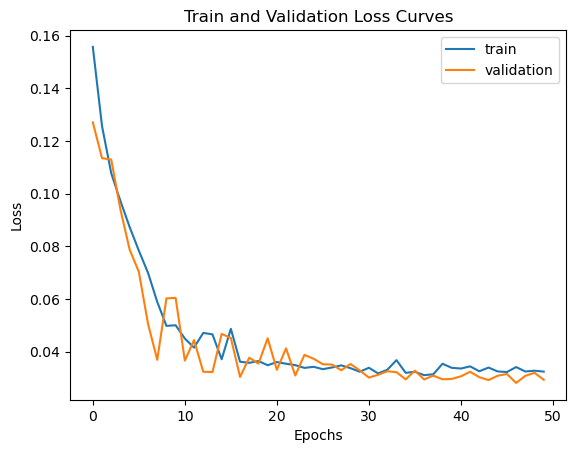

In [47]:
import matplotlib.pyplot as plt

history = fit(X_train,y_train,X_test,y_test)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.title("Train and Validation Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

And finally, we can see the performance of the model in the following graph:

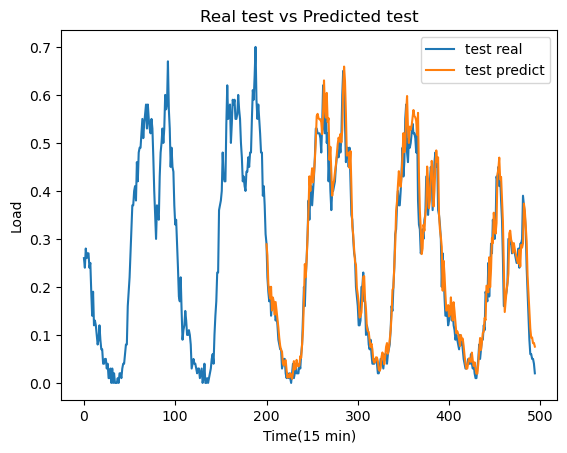

In [48]:
plt.plot(y_test, label='test real')
plt.plot(range(200,495), model.predict(X_test[200:], verbose=0).flatten(), label='test predict')
plt.title("Real test vs Predicted test")
plt.xlabel("Time(15 min)")
plt.ylabel("Load")
plt.legend(loc="upper right")
plt.show()

### Performance gains <a class="anchor" id="t33"></a>

As discussed earlier, all 4 bottlenecks were solved by migrating to the kdb+/q environment taking advantage of PyKX. Overall, the final picture looks like this:


|                  | Pandas Time      |  PyKX Time       |
| ---------------- | ---------------- | ---------------- |
| Cleaning Weather | 247 ms ± 10.4 ms | 26.7 ms ± 683 µs |
| Cleaning Traffic | 25.5 s ± 1.29 s  | 1.65 s ± 248 ms  |
| Join Final Table | 7.1 s ± 168 ms   | 686 ms ± 24.1 ms |
| Model Ingestion Preprocess |  3.2 s ± 54.2 ms  | 178 ms ± 8.01 ms|

So we got a 10x decrease across the board. We went from a total of 36 seconds spent on these bottlenecks down to just shy of 4 seconds, which is really impressive on itself. If a migration like this one was on the horizon, we would strongly suggest profiling the code to see where it struggles the most and try to think of a way to migrate those parts alone to PyKX. Then, as a second step, we recommend to port the rest of the code to PyKX in order to circumvent the overhead that moving data between memory spaces inherently adds to the process.

<div class="alert alert-block alert-info">
    <b> 🔍 You can find on Github the resulting <a href="https://github.com/hablapps/AllRoadsLeadToKdb/blob/main/src/pykx/PyKX_code.py">PyKX-enhanced pythonic code</a>. </b> 
</div>


## pykx.q migration <a class="anchor" id="t4"></a>


After gaining proficiency in the q language, the team progressively shifted towards utilizing `kx.q()` extensively, drawn by its brevity. Yet, this approach introduced a level of monotony due to the requirement of employing strings. As a remedy, a decision was made to transition into a q environment. However, as highlighted in the previous chapter, certain Python code proved challenging to migrate to q. Consequently, the team chose to remain within PyKX, this time operating within a q environment.

pykx.q facilitates the execution of Python code within a q environment, thereby presenting new avenues for addressing existing codebases. This flexibility enables the incorporation and utilization of Python libraries, both those installed on the system and those available as .py files.

In our scenario, we harness both of these options. We emphasize the potential provided by these opportunities to integrate Python code within pykx.q, while also providing a link to the project's [q script]() for readers seeking further insights.

<div class="alert alert-block alert-info">
    <b> 🔍 You can find on Github the resulting <a href="https://github.com/hablapps/AllRoadsLeadToKdb/tree/main/src/pykx.q">PyKX-enhanced kdb+/q code</a>.</b>
</div>

Our initial step involves executing the `haversine_vector` function for calculating coordinate distances. Given its unavailability in q, we opted to employ pykx.q to seamlessly integrate this library directly into our q code. This was achieved through the following lines:

```q
.pykx.pyexec"from haversine import haversine_vector, Unit";
```
<div class="alert alert-block alert-success" style="background-color: #FFFFFF; border: 0px solid; padding: 0px;box-shadow: 2px 2px #3841459c; border-left: 5px solid #00b100;margin-left: 5%; margin-right: 5%; border-top: 3px solid #00b100">
<div class="alert-header custom-card-header" style="background-color: #d8ffd8; border: 1px solid #d8ffd8; color: black; padding: 10px; font-size: 115%;">
<i class="fa fa-commenting" aria-hidden="true" style="color:#00b100"></i>&nbsp;&nbsp;&nbsp;Further Information on <a href="https://code.kx.com/pykx/1.6/user-guide/advanced/running_under_q.html">Python and Q Context</a> 
</div>
<div style="background-color: #e5ffdf70;  padding: 40px; padding-top:30px; padding-bottom:20px">
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> In PyKX.q, the python and q contexts coexists too. The utilization of <code>.pykx.pyexec</code> permits the execution of Python code within the q environment. When you're in the q context, you can work with python objects using the resources provided by pykx.q.These  incluede indexing, function declaration, and library importation. However, consistent with the recommendation of the previous chapter, it's generally better to stick with q objects for as long as you can.</p>
    
<p style="color: black; margin-top:0%; text-align: left;margin-left: 5%; margin-right: 5%; margin-bottom: 15px;font-size: 115%; line-weight: 1.5"> Objects from the Python memory can be retrieved using <code>pykx.get</code> and transmitted using <code>pykx.set</code>. The Python data type to be employed in the transformation can be specified using <code>.pykx.setdefault</code>.</p>
</div>
</div>

This function expects two Pandas DataFrames as input, so we need to change the default conversion type from Numpy to Pandas:

```q
.pykx.setdefault"pd";
```

Having done this, we can "move" our input variables to the Python memory space using `.pykx.set`

```q
.pykx.set[`a;`longitude`latitude#a];
.pykx.set[`b;`longitude`latitude#b];
```

And finally execute our function:

```q
(.pykx.eval"haversine_vector(a, b, Unit.KILOMETERS, comb=True)")`
```

Notice the backtick at the end, this is for converting back to a q type.



The other way we can run Python code is to load a .py (renamed to .p) file using `\l`. This could be done as follows:

```q
system"l kerasmodel.p";
```

Here we have included the functions `fit` and `predict` previously defined in last section. We can load them and use them like this:

```q
modelfit:.pykx.get`fit;
modelfit[train[0][3403];train[1][3403];test[0][3403];test[1][3403]];
modelpredict:.pykx.get`predict;
res:modelpredict[train[0][3403]];
```

In terms of performance, we noticed a slight decrease in execution time comparing to using PyKX:

|                            | Pandas Time      |  PyKX Time       |  q Time          |
| -------------------------- | ---------------- | ---------------- | ---------------- |
| Cleaning Weather           | 247 ms ± 10.4 ms | 26.7 ms ± 683 µs | 22.3 ms ± 224 µs |
| Cleaning Traffic           | 25.5 s ± 1.29 s  | 1.65 s ± 248 ms  | 1.627 s ± 124 ms |
| Join Final Table           | 7.1 s ± 168 ms   | 686 ms ± 24.1 ms | 543 ms ± 10.1 ms |
| Model Ingestion Preprocess |  3.2 s ± 54.2 ms | 178 ms ± 8.01 ms | 153 ms ± 3.12 ms |

These little timing shifts might happen because of changes in memory or processor activity, but it's not really noticeable as far as we could see.



## Final thoughts<a class="anchor" id="t5"></a>
Overall this project turned out smoother than expected thanks to PyKX. It allowed us to get a foothold on the kdb+/q ecosystem before making the full transition to using q code, which on itself it's impressive. We achieved our goals of reducing execution time, as we saw throughout this post, and learned a lot about the kdb+/q ecosystem and its technologies.

It wasn't all smooth and sail though. For instance, we hit a fundamental obstacle when using the Pandas API. In an ideal world, the transition from Pandas to PyKX using this API would be as simple as importing PyKX, enabling a flag and getting the input tables as PyKX objects. However, since we relied on operations such as `group_by` and `melt`, it ended up being unfeasible since these operations were not yet implemented and we would have to manually code them, which would take a long time on itself. We should note, however, that this feature is still on beta, so we look forward to future improvements in this regard since it would make migrations like this one much simpler once it becomes a drop-in replacement for Pandas calls.

In summary, with the experience we gained we dare to recommend you following these steps as a PyKX migration guide:

1. Migrate the original data to a kdb+/q environment or PyKX objects.
2. Profile the original code to locate bottlenecks. This allows us to put the focus on the heavier parts of our process.
3. Once located, migrate those parts alone to PyKX. You **will** take a performance hit when moving data from memory spaces, but 4t's important to know the potential gains that are possible, so measure the migrated bottlenecks alone to see the difference.
5. If your tables are not that large, you may be able to get away with it as-is, not needing to do a full migration. If that's the case then great! You are done. However, if you notice that the performance hit when moving data between memory spaces is actually hindering the process, consider a full migration to PyKX.
6. If a full migration to PyKX is needed, then first take a look at the Pandas API. By the time you read this, it may have already improved compatibility and could be a drop-in replacement for Pandas. If it's not the case you will need to familiarise yourself with PyKX and get your hands dirty as we had to.

We hope this post could serve as a guide of sorts for those that want to familiarise themselves with PyKX and the kdb+/q ecosystem since it brings a lot to the table. In the end we were able to achieve a full 1:1 migration to PyKX and even to q with pykx.q, which is impressive given the differences between the languages and their philosophy all while notably cutting execution time. Below you will find some additional references to continue learning PyKX. Have fun with PyKX!


## Bibliography <a class="anchor" id="t5"></a>

* *A. Morrison and N. Crone, Accelerating Python Workflows using PyKX, June 2023, KX Developers blog, https://kx.com/blog/accelerating-python-workflows-using-pykx/*
* *Reuben Taylor. An Introduction to PyKX https://kx.com/videos/an-introduction-to-pykx/ June, 2023*
* *Paul Walsh PyKX Boosts Trade Analytics https://www.treliant.com/knowledge-center/pykx-boosts-trade-analytics/ June 26, 2023*
* *Vidas M, Tubić V, Ivanović I, Subotić M. Sustainability (Basel) 2022; 14(9): e4985, http://dx.doi.org/10.3390/su14094985*  
* *Y. Yao et al., "Analyzing the Effects of Rainfall on Urban Traffic-Congestion Bottlenecks," in IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, vol. 13, pp. 504-512, 2020, http://dx.doi.org/10.1109/JSTARS.2020.2966591*  
* *Essien, A., Petrounias, I., Sampaio, P., & Sampaio, S. (2018). The Impact of Rainfall and Temperature on Peak and Off-Peak Urban Traffic. In Database and Expert Systems Applications : 28th International Conference, DEXA 2018, Regensburg, Germany. (pp. 399-407). (Lecture Notes in Computer Science). Springer Nature. https://doi.org/10.1007/978-3-319-98812-2_36*  